<a href="https://colab.research.google.com/github/y-kallel/applied-deep-learning/blob/main/FurnitureClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount drive to access dataset


*   [click](https://drive.google.com/drive/folders/10Uqr_lQUgamXQs5Z43PKwwuCRx6hG52b?usp=sharing) here to see the furniture dataset in drive
*   create shortcut to the My Drive folder
*   Run the below code to access from drive and upload to session storage







In [ ]:
from google.colab import drive
from pathlib import Path
drive.mount("/gdrive", force_remount=True)


Mounted at /gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%load_ext autoreload
%autoreload 2

import sys

from pathlib import Path
base = Path('/content/drive/MyDrive/furniture-images/img/')
sys.path.append(str(base))

In [ ]:
zip_path = base/'furniture_images.zip'
!cp "{zip_path}" .
!unzip -q furniture_images.zip
!rm furniture_images.zip

### Import Libraries



In [ ]:
import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import os
import random

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Access the downloaded dataset in the colab
Access the dataset directories and images

In [ ]:
base_dir = 'furniture-images/img'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
category = os.listdir(train_dir)

In [ ]:

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 1
ncols = 8

# Index for iterating over images
pic_index = 0

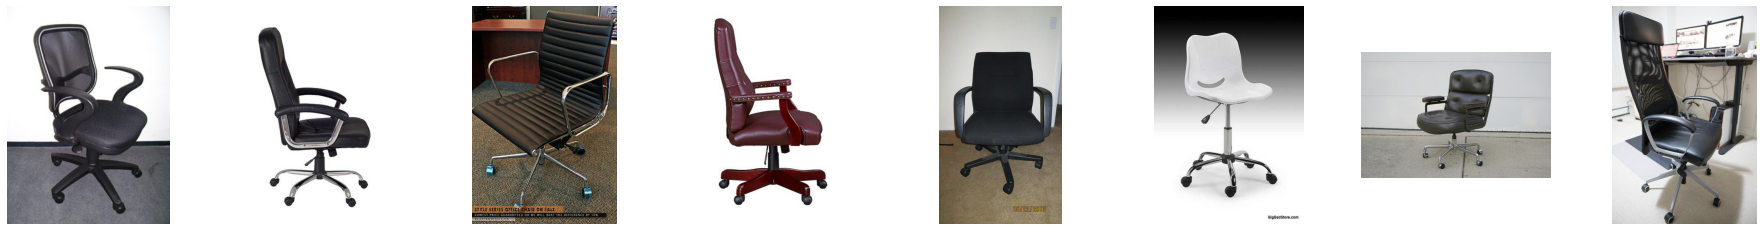

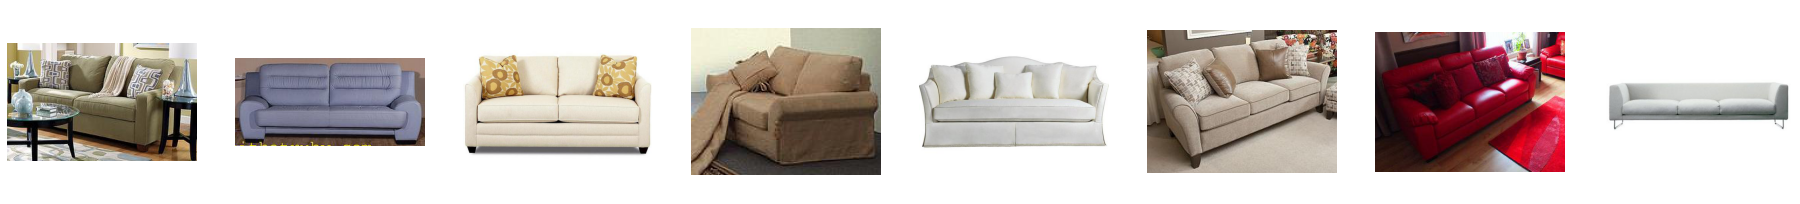

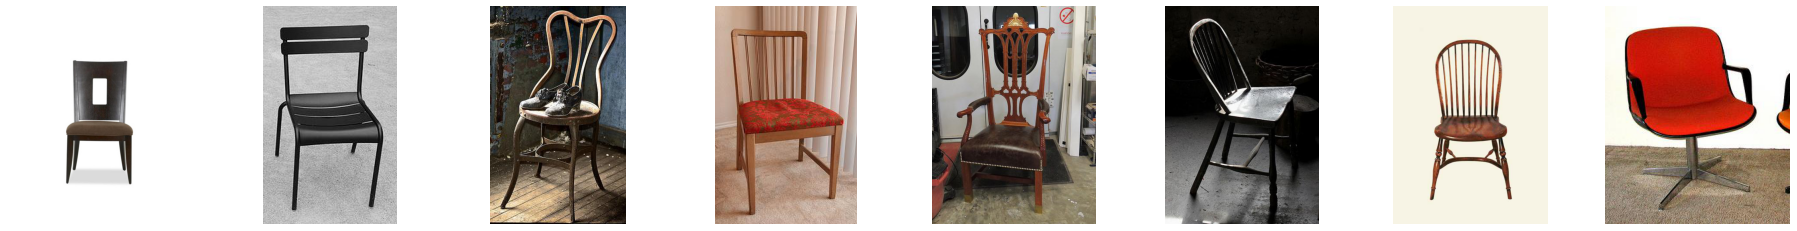

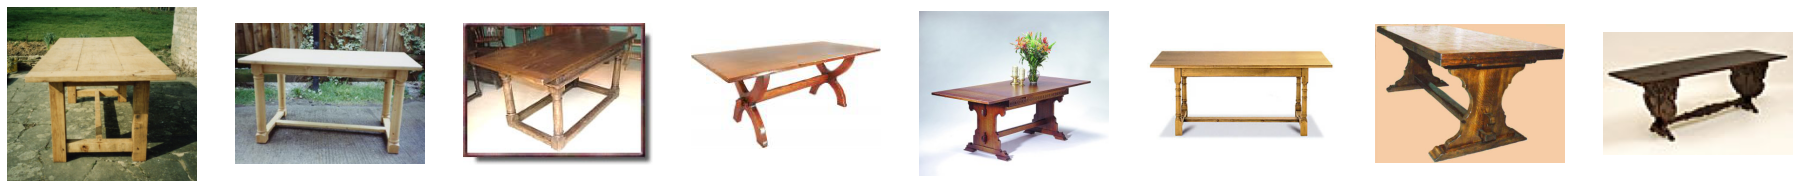

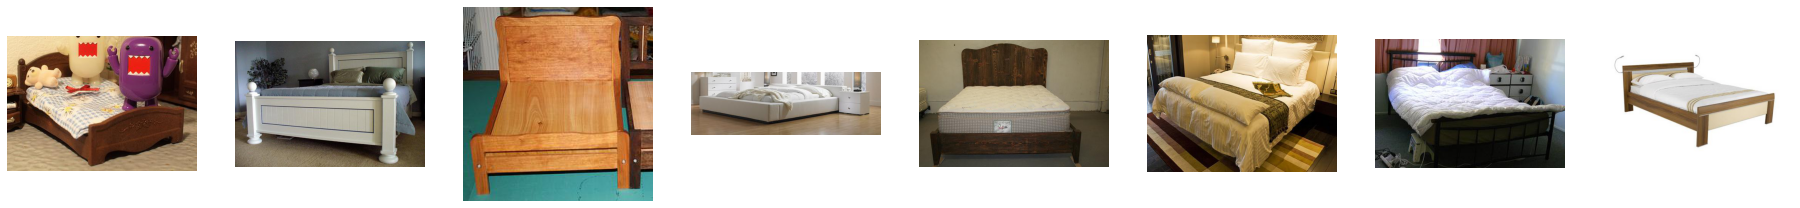

In [ ]:


pic_index += 8

for it in category:
  # Set up matplotlib fig, and size it to fit 4x4 pics
  fig = plt.gcf()
  fig.set_size_inches(ncols * 4, nrows * 4)
  train_cat_dir = os.path.join(train_dir, it)
  train_cat_fnames = os.listdir(train_cat_dir)
  next_pix = [os.path.join(train_cat_dir, fname) 
                  for fname in train_cat_fnames[pic_index-8:pic_index]]

  for i, img_path in enumerate(next_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

  plt.show()

In [ ]:
train_files = sum([len(files) for i, j, files in os.walk(train_dir)])
val_files = sum([len(files) for i, j, files in os.walk(val_dir)])
print(train_files, val_files)

4024 423


Set the hyperparameters

In [ ]:

n_classes = 4
epochs = 3
nb_train_samples = train_files
nb_validation_samples = val_files
num_epochs = epochs



img_width, img_height = 150, 150
train_data_dir = train_dir
validation_data_dir = val_dir
batch_size = 16



### Build a Model using tensorflow.keras.layers library
Model is using 3 convolution hidden layers with filter size 3 and activation function relu. The output layer has 5 output neurons with action function softmax

In [ ]:


# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

In [ ]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with 4 nodes and softmax activation
output = layers.Dense(4, activation='softmax')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

### Print model summary Plot the model architecture
Model architecture (model_plot.png image) is saved in the root folder of the session by running the below code.

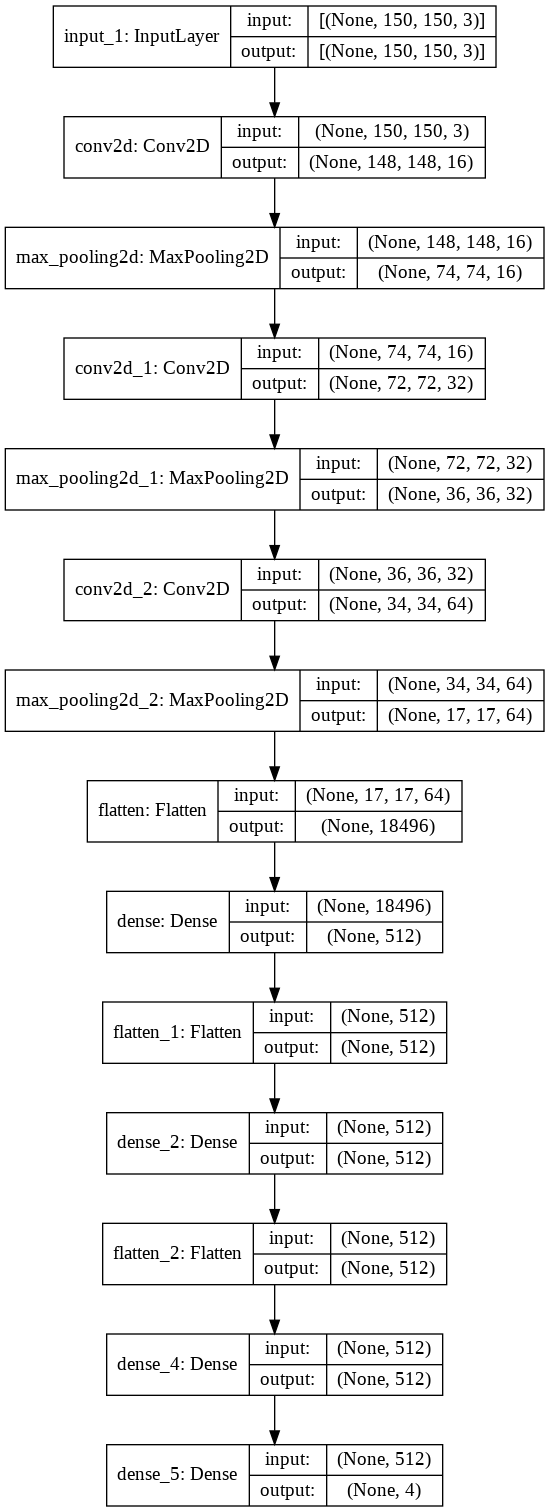

In [ ]:

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0   

### Run the model

In [ ]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


Found 4024 images belonging to 5 classes.
Found 423 images belonging to 5 classes.


In [ ]:
history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=num_epochs,
                    verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3


InvalidArgumentError: ignored

### Plot the Results
Show the accuracy and loss variations per epoch in the graph

In [ ]:

history.history

{'accuracy': [0.6259980201721191,
  0.7916666865348816,
  0.8475548624992371,
  0.8710079789161682,
  0.8917165398597717],
 'loss': [0.9801844954490662,
  0.5960331559181213,
  0.43781882524490356,
  0.3677322268486023,
  0.30495485663414],
 'val_accuracy': [0.7427884340286255,
  0.8533653616905212,
  0.8341346383094788,
  0.8629807829856873,
  0.8293269276618958],
 'val_loss': [0.7076132297515869,
  0.45039254426956177,
  0.4796521067619324,
  0.4217793047428131,
  0.5564709901809692]}

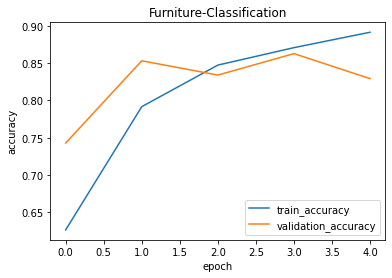

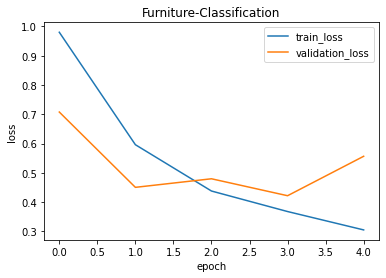

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'Furniture-Classification')
plot_loss(history,'Furniture-Classification')

# **Material Classification Model**

In [6]:
import math
import logging
import numpy as np
import torch
from scipy.misc import imread, imresize
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

#from kitnn.functions import StablePow

logger = logging.getLogger(__name__)


IMAGENET_MEAN = np.array([0.40760392, 0.45795686, 0.48501961])
SOBEL_KERNEL_X = Variable(torch.from_numpy(
    np.array([(1, 0, -1),
              (2, 0, -2),
              (1, 0, -1)]).astype(dtype=np.float32)),
                          requires_grad=False)
SOBEL_KERNEL_X = SOBEL_KERNEL_X.view(1, 1, *SOBEL_KERNEL_X.size())
SOBEL_KERNEL_Y = Variable(torch.from_numpy(
    np.array([(1, 2, 1),
              (0, 0, 0),
              (-1, -2, -1)]).astype(dtype=np.float32)),
                          requires_grad=False)
SOBEL_KERNEL_Y = SOBEL_KERNEL_Y.view(1, 1, *SOBEL_KERNEL_Y.size())

class StablePow(Function):

    def __init__(self, power):
        self.power = power

    def forward(self, input):
        self.save_for_backward(input)
        return input.clamp(min=0).pow(self.power)

    def backward(self, grad_output):
        input, = self.saved_tensors
        grad_input = grad_output.clone()
        eps = 0.00001
        grad_input[input <= eps] = eps
        grad_input[input > eps] = \
            self.power * grad_input[input > eps].pow(self.power - 1)
        return grad_input


class SerializationMixin:
    def load_npy(self, path):
        raise NotImplementedError()

    def save_pth(self, path):
        with open(path, 'wb') as f:
            torch.save(self, f)


def make_batch(images, flatten=False):
    if len(images[0].shape) == 2:
        images = [i[:, :, None] for i in images]
    batch = np.stack(images, axis=3) \
        .transpose((3, 2, 0, 1)) \
        .astype(dtype=np.float32)
    batch = torch.from_numpy(batch).contiguous()
    if flatten:
        batch.resize_(*batch.size()[:2], batch.size(2) * batch.size(3))
    return batch


def load_module_npy(module, data):
    for name, child in module._modules.items():
        if name in data:
            logger.info("Loading {} => {}".format(name, child))
            weight_shape = tuple(child.weight.size())
            weights = data[name]['weights']
            if weight_shape != weights.shape:
                logger.info("\tReshaping weight {} => {}"
                      .format(weights.shape, weight_shape))
                weights = weights.reshape(weight_shape)
            weights = torch.from_numpy(weights)
            bias = data[name]['biases']
            bias = torch.from_numpy(bias)
            child.weight.data.copy_(weights)
            child.bias.data.copy_(bias)


def to_imagenet(image):
    if image.dtype == np.uint8:
        image = image.astype(np.float32)
        image /= 255.0
    image = image.astype(np.float32)
    image[:, :, :3] = image[:, :, [2, 1, 0]]
    image[:, :, :3] -= IMAGENET_MEAN[None, None, :]
    return image


def from_imagenet(image):
    image = image.copy()[:, :, :3]
    image[:, :, :3] += IMAGENET_MEAN[None, None, :]
    image = image[:, :, [2, 1, 0]]
    return image


def softmax2d(x):
    e_x = np.exp(x - np.max(x, axis=-1)[:, :, None])
    return e_x / e_x.sum(axis=-1)[:, :, None]


def batch_to_images(batch, dtype=None):
    batch = batch.cpu()
    if not torch.is_tensor(batch):
        batch = batch.data
    if len(batch.size()) == 4:
        array = batch.numpy().reshape(
            batch.size(0), batch.size(1), batch.size(-2), batch.size(-1))\
            .transpose((0, 2, 3, 1))
    else:
        array = batch.numpy().reshape(
            batch.size(0), batch.size(-2), batch.size(-1)).transpose((0, 1, 2))
    if dtype is not None:
        return array.astype(dtype=dtype)
    return array


def gradient_image(batch):
    grady = F.conv2d(batch, SOBEL_KERNEL_Y.cuda())
    gradx = F.conv2d(batch, SOBEL_KERNEL_X.cuda())
    return grady, gradx


def normalize_batch(batch):
    if torch.is_tensor(batch):
        mean = batch.mean()
        std = batch.std()
    else:
        mean = batch.mean().view(*(1 for _ in batch.size())).expand(batch.size())
        std = batch.std().view(*(1 for _ in batch.size())).expand(batch.size())
    batch = (batch - mean) / std
    return batch


def batch_frobenius_norm(batch):
    batch = batch.view(batch.size(0), batch.size(1), -1)
    return (batch ** 2).sum(dim=2).squeeze().sqrt()


def rotation_tensor(theta, phi, psi, n_comps):
    rot_x = Variable(torch.zeros(n_comps, 3, 3).cuda(), requires_grad=False)
    rot_y = Variable(torch.zeros(n_comps, 3, 3).cuda(), requires_grad=False)
    rot_z = Variable(torch.zeros(n_comps, 3, 3).cuda(), requires_grad=False)
    rot_x[:, 0, 0] = 1
    rot_x[:, 0, 1] = 0
    rot_x[:, 0, 2] = 0
    rot_x[:, 1, 0] = 0
    rot_x[:, 1, 1] = theta.cos()
    rot_x[:, 1, 2] = theta.sin()
    rot_x[:, 2, 0] = 0
    rot_x[:, 2, 1] = -theta.sin()
    rot_x[:, 2, 2] = theta.cos()

    rot_y[:, 0, 0] = phi.cos()
    rot_y[:, 0, 1] = 0
    rot_y[:, 0, 2] = -phi.sin()
    rot_y[:, 1, 0] = 0
    rot_y[:, 1, 1] = 1
    rot_y[:, 1, 2] = 0
    rot_y[:, 2, 0] = phi.sin()
    rot_y[:, 2, 1] = 0
    rot_y[:, 2, 2] = phi.cos()

    rot_z[:, 0, 0] = psi.cos()
    rot_z[:, 0, 1] = -psi.sin()
    rot_z[:, 0, 2] = 0
    rot_z[:, 1, 0] = psi.sin()
    rot_z[:, 1, 1] = psi.cos()
    rot_z[:, 1, 2] = 0
    rot_z[:, 2, 0] = 0
    rot_z[:, 2, 1] = 0
    rot_z[:, 2, 2] = 1
    return torch.bmm(rot_z, torch.bmm(rot_y, rot_x))

ImportError: ignored

In [ ]:
from collections import OrderedDict

import numpy as np
from torch import nn

class VGG16(nn.Module, SerializationMixin):
    def __init__(self, pool_module=nn.MaxPool2d):
        super().__init__()

        self.features = SelectiveSequential(OrderedDict([
            ('conv1_1', nn.Conv2d(3, 64, kernel_size=3, padding=1)),
            ('relu1_1', nn.ReLU(inplace=True)),
            ('conv1_2', nn.Conv2d(64, 64, kernel_size=3, padding=1)),
            ('relu1_2', nn.ReLU(inplace=True)),
            ('pool1', pool_module(kernel_size=2, stride=2)),

            ('conv2_1', nn.Conv2d(64, 128, kernel_size=3, padding=1)),
            ('relu2_1', nn.ReLU(inplace=True)),
            ('conv2_2', nn.Conv2d(128, 128, kernel_size=3, padding=1)),
            ('relu2_2', nn.ReLU(inplace=True)),
            ('pool2', pool_module(kernel_size=2, stride=2)),

            ('conv3_1', nn.Conv2d(128, 256, kernel_size=3, padding=1)),
            ('relu3_1', nn.ReLU(inplace=True)),
            ('conv3_2', nn.Conv2d(256, 256, kernel_size=3, padding=1)),
            ('relu3_2', nn.ReLU(inplace=True)),
            ('conv3_3', nn.Conv2d(256, 256, kernel_size=3, padding=1)),
            ('relu3_3', nn.ReLU(inplace=True)),
            ('pool3', pool_module(kernel_size=2, stride=2)),

            ('conv4_1', nn.Conv2d(256, 512, kernel_size=3, padding=1)),
            ('relu4_1', nn.ReLU(inplace=True)),
            ('conv4_2', nn.Conv2d(512, 512, kernel_size=3, padding=1)),
            ('relu4_2', nn.ReLU(inplace=True)),
            ('conv4_3', nn.Conv2d(512, 512, kernel_size=3, padding=1)),
            ('relu4_3', nn.ReLU(inplace=True)),
            ('pool4', pool_module(kernel_size=2, stride=2)),

            ('conv5_1', nn.Conv2d(512, 512, kernel_size=3, padding=1)),
            ('relu5_1', nn.ReLU(inplace=True)),
            ('conv5_2', nn.Conv2d(512, 512, kernel_size=3, padding=1)),
            ('relu5_2', nn.ReLU(inplace=True)),
            ('conv5_3', nn.Conv2d(512, 512, kernel_size=3, padding=1)),
            ('relu5_3', nn.ReLU(inplace=True)),
            ('pool5', pool_module(kernel_size=2, stride=2)),
        ]))

    def forward(self, x, selection=list()):
        return self.features(x, selection)

    def load_npy(self, path):
        with open(path, 'rb') as f:
            data = np.load(f)[()]
        load_module_npy(self.features, data)

In [ ]:
from collections import OrderedDict

from torch import nn
from torch.autograd import Variable
from torch.legacy.nn import SpatialCrossMapLRN
from torch.autograd import Function

class SelectiveSequential(nn.Module):
    def __init__(self, modules_dict):
        super().__init__()
        self.modules_dict = OrderedDict(modules_dict.items())
        for key, module in modules_dict.items():
            self.add_module(key, module)

    def forward(self, x, selection=list()):
        selection_dict = OrderedDict({})
        for name, module in self.modules_dict.items():
            x = module(x)
            if name in selection:
                selection_dict[name] = x
        if len(selection) == 0:
            return x
        return x, selection_dict


class LRN(nn.Module):
    def __init__(self, size, alpha=1e-4, beta=0.75, k=1):
        super().__init__()
        self.lrn = SpatialCrossMapLRN(size, alpha, beta, k)

    def forward(self, x):
        self.lrn.clearState()
        return Variable(self.lrn.updateOutput(x.data))

In [5]:
import logging
from collections import OrderedDict
!pip3 install pydensecrf
import numpy as np
from pydensecrf import densecrf
from skimage.color import rgb2lab
from torch import nn

from toolbox.images import resize

logger = logging.getLogger(__name__)


SUBSTANCES = [
    'brick',
    'carpet',
    'ceramic',
    'fabric',
    'foliage',
    'food',
    'glass',
    'hair',
    'leather',
    'metal',
    'mirror',
    'other',
    'painted',
    'paper',
    'plastic',
    'polishedstone',
    'skin',
    'sky',
    'stone',
    'tile',
    'wallpaper',
    'water',
    'wood'
]
REMAPPED_SUBSTANCES = [
    'fabric',
    'leather',
    'wood',
    'metal',
    'plastic',
    'background',
]
SUBST_MAPPING = OrderedDict([
    ('fabric', 'fabric'),
    ('carpet', 'fabric'),
    ('leather', 'leather'),
    ('wood', 'wood'),
    ('metal', 'metal'),
    ('plastic', 'plastic'),
])
RT2 = np.sqrt(2)


def compute_remapped_probs(probs: np.ndarray, fg_mask=None):
    fg_inds = [i for i, s in enumerate(REMAPPED_SUBSTANCES)
               if s != 'background']
    bg_idx = REMAPPED_SUBSTANCES.index('background')
    remapped = np.zeros((*probs.shape[:2], len(REMAPPED_SUBSTANCES)))
    for subst_old, subst_new in SUBST_MAPPING.items():
        old_idx = SUBSTANCES.index(subst_old)
        new_idx = REMAPPED_SUBSTANCES.index(subst_new)
        remapped[:, :, new_idx] += probs[:, :, old_idx]
    if fg_mask is None:
        remapped[remapped[:,:,:4].max(axis=2) < 0.2, bg_idx] = 1.0
    else:
        remapped[~fg_mask, bg_idx] = 2.0
        remapped[fg_mask, bg_idx] = -5
    remapped = softmax2d(remapped)
    return remapped


def preprocess_image(image):
    if image.max() > 1.0:
        logger.warning("Image has values larger than 1.0, this function"
                       " expects all images to be single between 0.0 and 1.0!")
    image = image.copy()
    processed = image.astype(np.float32) * 255.0
    processed = processed[:, :, [2, 1, 0]]
    processed[:, :, 0] -= 104.0
    processed[:, :, 1] -= 117.0
    processed[:, :, 2] -= 124.0
    return processed


def resize_image(image, scale=1.0, l_size=256, l_frac=0.233, order=2):
    small_dim_len = l_size / l_frac
    scale_mult = scale * small_dim_len / min(image.shape[:2])
    scale_shape = (int(image.shape[0] * scale_mult),
                   int(image.shape[1] * scale_mult))
    return resize(image, scale_shape, order=order)


def combine_probs(prob_maps, image, remap=False, fg_mask=None):
    substances = REMAPPED_SUBSTANCES if remap else SUBSTANCES
    map_scale = 550 / min(image.shape[:2])
    map_sum = np.zeros((int(image.shape[0] * map_scale),
                        int(image.shape[1] * map_scale),
                        len(substances)))
    for prob_map in prob_maps:
        if remap:
            resized_fg_mask = resize(fg_mask, prob_map.shape, order=0)
            prob_map = compute_remapped_probs(
                prob_map, fg_mask=resized_fg_mask)
        prob_map = resize(prob_map, map_sum.shape[:2])
        map_sum += prob_map
    return map_sum / len(prob_maps)


def compute_probs_multiscale(
        image, mincnet, scales=list([RT2, 1.0, 1 / RT2]), use_cuda=True):
    prob_maps = []
    feat_dicts = []
    for scale in scales:
        image_scaled = resize_image(image, scale=scale)
        logger.info("\tProcessing scale={:.4}, shape={}"
                    .format(scale, image_scaled.shape))
        batch_arr = make_batch([image_scaled])
        if use_cuda:
            batch_arr = batch_arr.cuda()
        # batch = Variable(batch_arr, volatile=True)
        prob_map, sel_dict = mincnet(batch_arr, selection=['fc8-20', 'softmax'])
        prob_map_numpy = prob_map.cpu().data.numpy()[0].transpose((1, 2, 0))
        prob_maps.append(prob_map_numpy)
        feat_dicts.append(sel_dict)
    return prob_maps, feat_dicts


def compute_probs_crf(
        image, prob_map, theta_p=0.1, theta_L=10.0, theta_ab=5.0):
    resized_im = np.clip(resize(image, prob_map.shape[:2], order=3), 0, 1)
    image_lab = rgb2lab(resized_im)

    p_y, p_x = np.mgrid[0:image_lab.shape[0], 0:image_lab.shape[1]]

    feats = np.zeros((5, *image_lab.shape[:2]), dtype=np.float32)
    d = min(image_lab.shape[:2])
    feats[0] = p_x / (theta_p * d)
    feats[1] = p_y / (theta_p * d)
    feats[2] = image_lab[:, :, 0] / theta_L
    feats[3] = image_lab[:, :, 1] / theta_ab
    feats[4] = image_lab[:, :, 2] / theta_ab
    crf = densecrf.DenseCRF2D(*prob_map.shape)
    unary = np.rollaxis(
        -np.log(prob_map), axis=-1).astype(dtype=np.float32, order='c')
    crf.setUnaryEnergy(np.reshape(unary, (prob_map.shape[-1], -1)))

    compat = 2*np.array((
        # f    l    w    m    p    b
        (0.0, 1.0, 1.0, 1.0, 1.0, 3.0),  # fabric
        (1.0, 0.0, 1.0, 1.0, 1.0, 3.0),  # leather
        (1.0, 1.0, 0.0, 1.0, 1.0, 3.0),  # wood
        (1.0, 1.0, 1.0, 0.0, 1.0, 3.0),  # metal
        (1.0, 1.0, 1.0, 1.0, 0.0, 3.0),  # plastic
        (1.5, 1.5, 1.5, 1.5, 1.5, 0.0),  # background
    ), dtype=np.float32)

    crf.addPairwiseEnergy(np.reshape(feats, (feats.shape[0], -1)),
                          compat=compat)

    Q = crf.inference(20)
    Q = np.array(Q).reshape((-1, *prob_map.shape[:2]))
    return np.rollaxis(Q, 0, 3)


class MincAlexNet(nn.Module, SerializationMixin):
    def __init__(self):
        super().__init__()
        self.features = AlexNet().features
        self.classifier = SelectiveSequential(OrderedDict([
            ('fc6', nn.Conv2d(256, 4096, kernel_size=6, stride=1, padding=3)),
            ('relu6', nn.ReLU(inplace=True)),
            ('fc7', nn.Conv2d(4096, 4096, kernel_size=1, stride=1)),
            ('relu7', nn.ReLU(inplace=True)),
            ('fc8-20', nn.Conv2d(4096, 23, kernel_size=1, stride=1)),
            ('softmax', nn.Softmax2d())
        ]))

    def forward(self, x):
        features = self.features(x, selection=['pool5'])[0]
        softmax = self.classifier(features, ['softmax'])[0]
        return softmax

    def load_npy(self, path):
        with open(path, 'rb') as f:
            data = np.load(f)[()]
        load_module_npy(self.features, data)
        load_module_npy(self.classifier, data)


class MincVGG(nn.Module, SerializationMixin):
    def __init__(self):
        super().__init__()
        self.features = VGG16().features
        self.classifier = SelectiveSequential(OrderedDict([
            ('fc6', nn.Conv2d(512, 4096, kernel_size=7, stride=1, padding=3)),
            ('relu6', nn.ReLU(True)),
            ('fc7', nn.Conv2d(4096, 4096, kernel_size=1, stride=1)),
            ('relu7', nn.ReLU(True)),
            ('fc8-20', nn.Conv2d(4096, 23, kernel_size=1, stride=1)),
            ('softmax', nn.Softmax2d())
        ]))

    def forward(self, x, selection=None):
        if selection is None:
            selection = ['softmax']
        feature_sel = {'pool5'}
        classifier_sel = set()
        for sel in selection:
            if sel in self.features.modules_dict:
                feature_sel.add(sel)
            elif sel in self.classifier.modules_dict:
                classifier_sel.add(sel)
            else:
                logger.warning('layer %s does not exist in modules', sel)
        x, features = self.features(x, selection=feature_sel)
        x, classifier = self.classifier(x, selection=classifier_sel)
        return x, {**features, **classifier}

    def load_npy(self, path):
        with open(path, 'rb') as f:
            data = np.load(f)[()]
        load_module_npy(self.features, data)
        load_module_npy(self.classifier, data)


class AlexNet(nn.Module, SerializationMixin):
    def __init__(self):
        super().__init__()
        self.features = SelectiveSequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0)),
            ('relu1', nn.ReLU(inplace=True)),
            ('norm1', LRN(5, 0.0001, 0.75, 1)),
            ('pool1', nn.MaxPool2d(kernel_size=3, stride=2)),

            ('conv2', nn.Conv2d(96, 256, kernel_size=5, padding=2, groups=2)),
            ('relu2', nn.ReLU(inplace=True)),
            ('norm2', LRN(5, 0.0001, 0.75, 1)),
            ('pool2', nn.MaxPool2d(kernel_size=3, stride=2)),

            ('conv3', nn.Conv2d(256, 384, kernel_size=3, padding=1)),
            ('relu3', nn.ReLU(inplace=True)),

            ('conv4', nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2)),
            ('relu4', nn.ReLU(inplace=False)),

            ('conv5', nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2)),
            ('relu5', nn.ReLU(inplace=True)),
            ('pool5', nn.MaxPool2d(kernel_size=3, stride=2)),
        ]))

    def forward(self, x, selection=list()):
        return self.features(x, selection)

    def load_npy(self, path):
        with open(path, 'rb') as f:
            data = np.load(f)[()]
        load_module_npy(self.features, data)

  Using cached https://files.pythonhosted.org/packages/31/5a/1c2ab48e8019d282c128bc5c621332267bb954d32eecdda3ba57306b1551/pydensecrf-1.0rc3.tar.gz
  ERROR: Failed building wheel for pydensecrf
  Running setup.py clean for pydensecrf
Failed to build pydensecrf
    Running setup.py install for pydensecrf ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-fafl6lyk/pydensecrf/setup.py'"'"'; __file__='"'"'/tmp/pip-install-fafl6lyk/pydensecrf/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-_ybe5pye/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


ModuleNotFoundError: ignored

In [ ]:
import skimage
import skimage.io
import numpy as np
import toolbox.images


mincnet = MincVGG()
mincnet.load_npy('content/minc.npy')
mincnet = mincnet.cuda()

image = skimage.img_as_float32(skimage.io.imread('content/test.png'))

subst_map, _ = compute_substance_map(mincnet, image)
subst_map = toolbox.images.resize(
    subst_map, shape=IMAGE_SHAPE, order=0)
    

def compute_substance_map(mincnet, image, fg_mask=None):
    if fg_mask is None:
        fg_mask = np.ones(image.shape[:2], dtype=bool)
    processed_image = minc.preprocess_image(image)

    prob_maps, feat_dicts = compute_probs_multiscale(
        processed_image, mincnet, use_cuda=True)
    prob_map_avg = minc.combine_probs(prob_maps, processed_image,
                                      remap=True, fg_mask=fg_mask)

    prob_map_crf = minc.compute_probs_crf(image, prob_map_avg)
    prob_map_crf = toolbox.images.resize(
        prob_map_crf, processed_image.shape[:2], order=3)
    subst_id_map = np.argmax(prob_map_crf, axis=-1)
    return subst_id_map, prob_map_crf